In [2]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from dPCA import dPCA
from get_utils import get_data, get_dir
import numpy as np
import plot as plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch as th
%matplotlib widget
#%matplotlib qt
#%matplotlib inline

In [128]:
folder_name = 'Sim_simple'
model_name = 'model{:02d}'.format(18)


# Load data
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
U = get_data(folder_name,model_name,phase,ff_coef=None) #,batch_size=300,catch_trial_perc=0,condition='train',go_cue_random=False

n_muscle = 6
weight_file,_,_= get_dir(folder_name,model_name,'NF1',0)
W = th.load(weight_file)['fc.weight'].numpy()
_, _, Vh = np.linalg.svd(W, full_matrices=True)
V = Vh.T
P = V[:,:n_muscle].T # output potent: ...x neurons
N = V[:,n_muscle:].T # output null space: ...x neurons


data = []
for i in range(len(U)):
    data.append(np.array(U[i]['all_hidden'])) # size: n_trials x n_timepoints x n_neurons   (8, 100, 128)

X = np.concatenate([d[:,None,:,:] for d in data], axis=1)
X = X.transpose(3,0,1,2) # neurons x conditions x phase x time

# remove the overall mean
#X = X - np.mean(X, axis=(1,2,3))[:,None,None,None]

# project into the output potent space
X = np.einsum('ij,jklm->iklm', N, X)

X_1 = X[:,:,:2,:]
X_2 = X[:,:,2:,:]

dpca = dPCA.dPCA(labels='clt',join={'ct':['c','ct'], 'lt':['l','lt'], 'clt':['cl','clt']}, n_components=6,n_iter='auto') # {'ct':['c','ct'], 'l':['l'],'lt':['lt'], 'clt':['cl','clt']}
dpca.protect = ['t']
dpca.fit(X_1)
Z = dpca.transform(np.concatenate((X_1,X_2),axis=2))
#Z = dpca.transform(X_1)

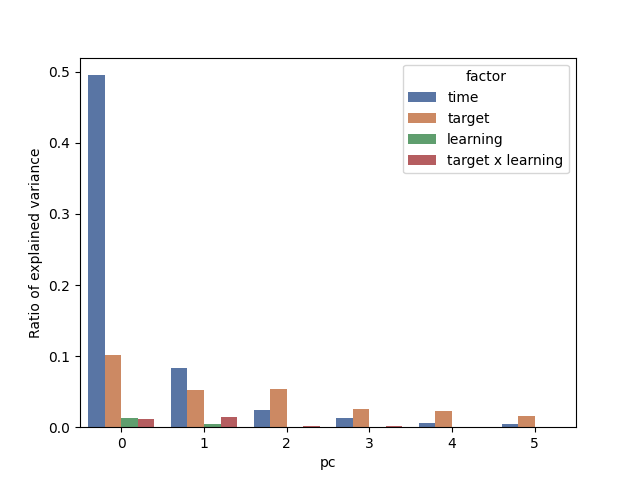

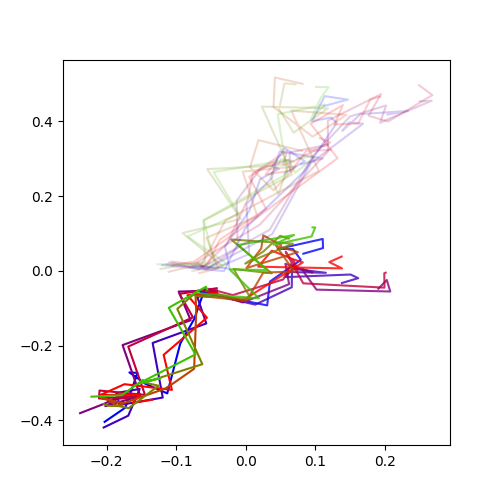

In [129]:
#names = ['time','target','learning','learningxtime','target x learning']
names = ['time','target','learning','target x learning']
var = dpca.explained_variance_ratio_
var_df = pd.DataFrame(columns=['factor', 'pc', 'variance_explained'])

counter = 0
for i,name in enumerate(var.keys()):
    for c in range(dpca.n_components):
        var_df.loc[counter] = {'factor': names[i], 'pc': c,'variance_explained': var[name][c]}
        counter += 1

# Plot
fig,ax = plt.subplots()
sns.barplot(var_df, x='pc', y='variance_explained', hue='factor', palette=sns.color_palette('deep',4))
ax.set_ylabel('Ratio of explained variance')


# neurons x conditions x phase x time
x_1 = Z['lt'][:,:,0,:].transpose(1,2,0)
x_2 = Z['lt'][:,:,1,:].transpose(1,2,0)

x = []
for i in range(Z['lt'].shape[2]):
    x.append(Z['lt'][:,:,i,:].transpose(1,2,0))


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111) #, projection='3d'

plot.plot_traj(ax,x,which_times=list(range(0,10)),plot_scatter=0,dim=2,alpha=[1,0.2,0.8,0.2])

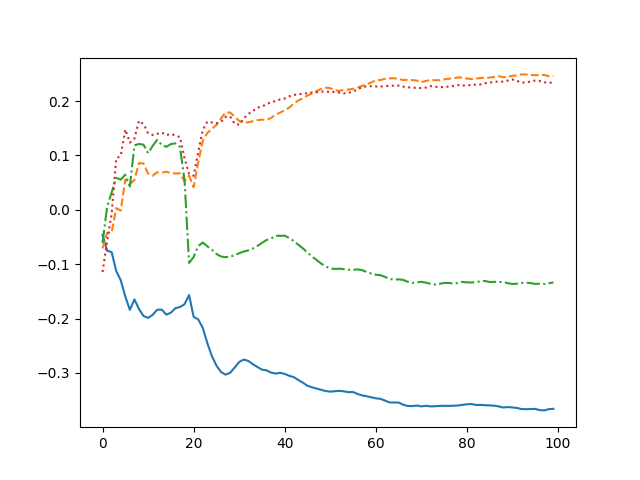

In [130]:
fig = plt.figure()
x_1[:,:,1].shape
#plt.plot(np.mean(x_1[:,:,0],axis=0).T)
#plt.plot(np.mean(x_2[:,:,0],axis=0).T,linestyle='--')

linestyle = ['-', '--', '-.', ':']
for i in range(len(x)):
    plt.plot(np.mean(x[i][:,:,0],axis=0).T,linestyle=linestyle[i])
    #plt.plot(x[i][:,:,0].T,linestyle=linestyle[i])